# Poisson Distribution & Regression

## Poisson Distribution

- See Wikipedia.com

## Poisson Regression
- Examples from [Beyond Multiple Linear Regression:
Applied Generalized Linear Models and Multilevel Models in R,
Paul Roback and Julie Legler, 2021](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html)
    - This book is not for Bayesian Inference.
    - https://github.com/proback/BeyondMLR.git
    
## When to use Poisson Regression?
1. Does the number of employers conducting on-campus interviews during a year differ for public and private colleges?
1. Does the daily number of asthma-related visits to an Emergency Room differ depending on air pollution indices?
1. Has the number of deformed fish in randomly selected Minnesota lakes been affected by changes in trace minerals in the water over the last decade?
1. Are the number of motorcycle deaths in a given year related to a state’s helmet laws?

## Poisson Regression Assumptions:

Using Poisson regression to make inferences requires model assumptions.

1. Poisson Response 
    - The response variable is a count per unit of time or space, described by a Poisson distribution.
1. Independence 
    - The observations must be independent of one another.
1. Mean=Variance 
    - By definition, the mean of a Poisson random variable must be equal to its variance.
1. Linearity 
    - The log of the mean rate, log( λ ), must be a linear function of x.

In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print('          Med  MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f}   {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

## A graphical look at Poisson Regression

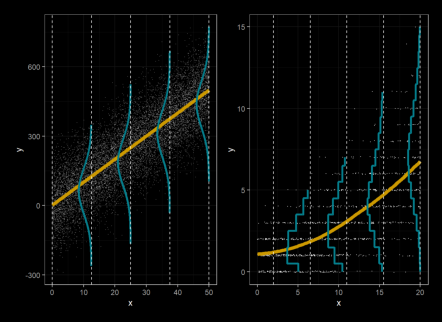

In [4]:
from skimage import io
im = io.imread('Data/OLSpois-1.png')
nim = 255 - im[:,:,:3]
plt.imshow(nim, ); plt.axis('off');

## Simulation Study
- ROS Chapter 15.2

Poisson Model:
$$
    y_i \sim \mathrm{Poisson}(e^{X_i\beta})
$$

- Under the Poisson model, $std(y_i) = \sqrt{\mathbb{E}(y_i)}$; thus if the model accurately describes the data, we also have a sense of how much variation we would expect from the fitted curve.

(400,) (400,)


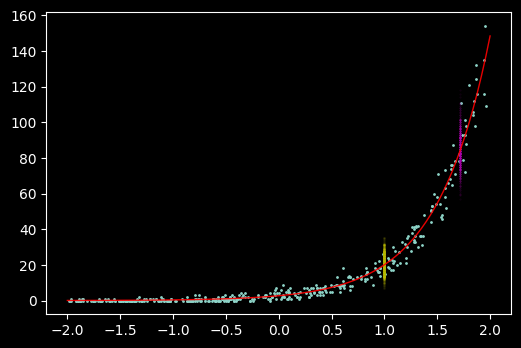

In [5]:
n = 400
x = np.random.random(n)*4 - 2
a = 1
b = 2
linpred = a + b * x

y = stats.poisson(mu=np.exp(linpred)).rvs()

print(x.shape, y.shape)
fake = pd.DataFrame(dict(x=x, y=y))
plt.scatter(x, y, s=1);

x0 = np.array([1.]*1000)
y0 = stats.poisson(mu=np.exp(a + b * x0)).rvs()
plt.scatter(x0, y0, s=1, alpha=.1, color='y')

x0 = np.array([1.72]*1000)
y0 = stats.poisson(mu=np.exp(a + b * x0)).rvs()
plt.scatter(x0, y0, s=.151, alpha=.1, color='m')

# red curve: mean curve
xgrid = np.linspace(-2, 2, 100)
ygrid = np.exp(a + b * xgrid)
plt.plot(xgrid, ygrid, 'r-', alpha=.9, linewidth=1);

In [6]:
def model(x, y):
    a = numpyro.sample('a', dist.Normal(0, 5))
    b = numpyro.sample('b', dist.Normal(0, 5))
    
    lograte = a + b * x
    rate = jnp.exp(lograte)
    
    with numpyro.plate('obsplate', size=len(x)):
        obs = numpyro.sample('obs', dist.Poisson(rate), obs=y)

In [7]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)
#
#
mcmc.run(rngkey, x, y)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 6000/6000 [00:06<00:00, 900.26it/s, 1 steps of size 2.07e-01. acc. prob=0.94]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a      1.03      0.04      1.02      0.98      1.07   1208.29      1.00
         b      1.98      0.02      1.98      1.96      2.01   1220.89      1.00

Number of divergences: 0


In [8]:
s = mcmc.get_samples()
s

{'a': DeviceArray([1.0467607 , 1.0501229 , 1.0609246 , ..., 1.0055536 ,
              0.99127984, 0.9947612 ], dtype=float32),
 'b': DeviceArray([1.9778951, 1.9512563, 1.9747462, ..., 1.9928068, 1.9890153,
              1.9889705], dtype=float32)}

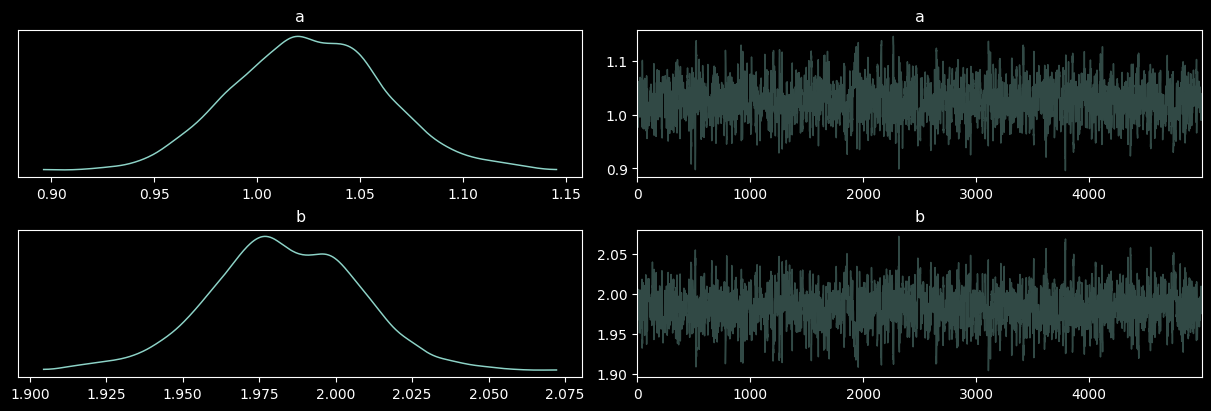

In [9]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['a', 'b']);

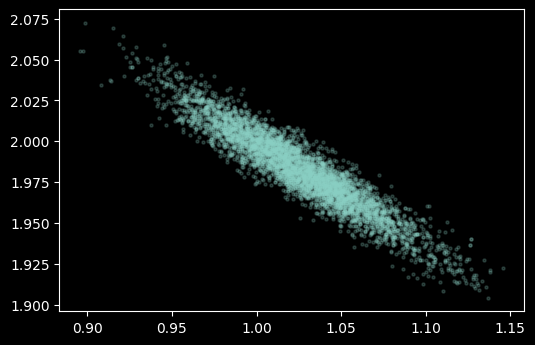

In [10]:
plt.scatter(s['a'], s['b'], s=5, alpha=.2);

In [11]:
print_abs_summary(s)

          Med  MAD_SD
a       +1.025   +0.037
b       +1.983   +0.024


In [12]:
am, bm = s['a'].mean(), s['b'].mean()

Text(0, 0.5, 'y')

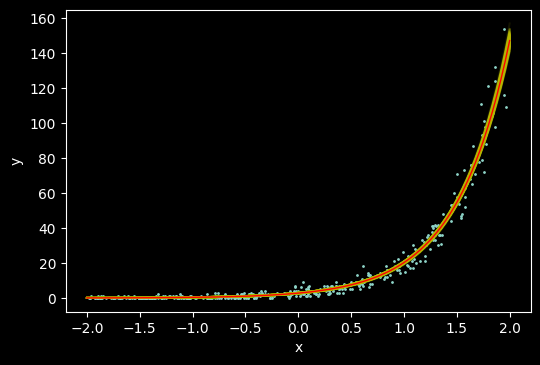

In [13]:
# data plot
plt.scatter(x, y, s=1);

# samples rate curve
for i, (sa, sb) in enumerate(zip(s['a'], s['b'])):
    plt.plot(xgrid, np.exp(sa + sb * xgrid), 'y', alpha=.1)
    if i > 500: break

# posterior mean rate curve
plt.plot(xgrid, np.exp(am + bm * xgrid), 'r', linewidth=1);
plt.xlabel('x')
plt.ylabel('y')

---
## Case Study: Household Size in the Philippines

How many other people live with you in your home? The number of people sharing a house differs from country to country and often from region to region. International agencies use household size when determining needs of populations, and the household sizes determine the magnitude of the household needs.

The Philippine Statistics Authority (PSA) spearheads the Family Income and Expenditure Survey (FIES) nationwide. The survey, which is undertaken every three years, is aimed at providing data on family income and expenditure, including levels of consumption by item of expenditure. Our data, from the 2015 FIES, is a subset of 1500 of the 40,000 observations (Philippine Statistics Authority 2015). Our data set focuses on five regions: Central Luzon, Metro Manila, Ilocos, Davao, and Visayas (see Figure 4.2).

At what age are heads of households in the Philippines most likely to find the largest number of people in their household? Is this association similar for poorer households (measured by the presence of a roof made from predominantly light/salvaged materials)? We begin by explicitly defining our response,  
Y
=
  number of household members other than the head of the household. We then define the explanatory variables: age of the head of the household, type of roof (predominantly light/salvaged material or predominantly strong material), and location (Central Luzon, Davao Region, Ilocos Region, Metro Manila, or Visayas). Note that predominantly light/salvaged materials are a combination of light material, mixed but predominantly light material, and mixed but predominantly salvaged material, and salvaged matrial. Our response is a count, so we consider a Poisson regression where the parameter of interest is  
λ
 , the average number of people, other than the head, per household. We will primarily examine the relationship between household size and age of the head of household, controlling for location and income.

## Data Organization

The first five rows from our data set fHH1.csv are illustrated in Table 4.1. Each line of the data file refers to a household at the time of the survey:

- location = where the house is located (Central Luzon, Davao Region, Ilocos Region, Metro Manila, or Visayas)
- age = the age of the head of household
- total = the number of people in the household other than the head
- numLT5 = the number in the household under 5 years of age
- roof = the type of roof in the household (either Predominantly Light/Salvaged Material, or Predominantly Strong Material, where stronger material can sometimes be used as a proxy for greater wealth)

In [14]:
df = pd.read_csv('Data/BeyondML/data/fHH1.csv')
df

,Unnamed: 0,location,age,total,numLT5,roof
0,1,CentralLuzon,65,0,0,Predominantly Strong Material
1,2,MetroManila,75,3,0,Predominantly Strong Material
2,3,DavaoRegion,54,4,0,Predominantly Strong Material
3,4,Visayas,49,3,0,Predominantly Strong Material
4,5,MetroManila,74,3,0,Predominantly Strong Material
...,...,...,...,...,...,...
1495,1496,Visayas,37,2,0,Predominantly Strong Material
1496,1497,MetroManila,45,3,1,Predominantly Strong Material
1497,1498,MetroManila,34,4,1,Predominantly Strong Material
1498,1499,IlocosRegion,58,3,0,Predominantly Strong Material


In [15]:
df = df[['location', 'age', 'total']].copy()

In [16]:
df['age100'] = df['age'] / 100

In [17]:
df['age1002'] = df.age100 * df.age100
df

,location,age,total,age100,age1002
0,CentralLuzon,65,0,0.65,0.4225
1,MetroManila,75,3,0.75,0.5625
2,DavaoRegion,54,4,0.54,0.2916
3,Visayas,49,3,0.49,0.2401
4,MetroManila,74,3,0.74,0.5476
...,...,...,...,...,...
1495,Visayas,37,2,0.37,0.1369
1496,MetroManila,45,3,0.45,0.2025
1497,MetroManila,34,4,0.34,0.1156
1498,IlocosRegion,58,3,0.58,0.3364


## Exploratory Data Analyses

In [18]:
df.describe()

,age,total,age100,age1002
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,52.715333,3.684667,0.527153,0.298858
std,14.485056,2.352500,0.144851,0.159159
min,18.000000,0.000000,0.180000,0.032400
25%,42.000000,2.000000,0.420000,0.176400
50%,52.000000,3.000000,0.520000,0.270400
75%,63.250000,5.000000,0.632500,0.400075
max,98.000000,16.000000,0.980000,0.960400


In [19]:
df.total.mean(), df.total.std()**2   # approximately similar? 

(3.6846666666666668, 5.5342543918167655)

### Histograms

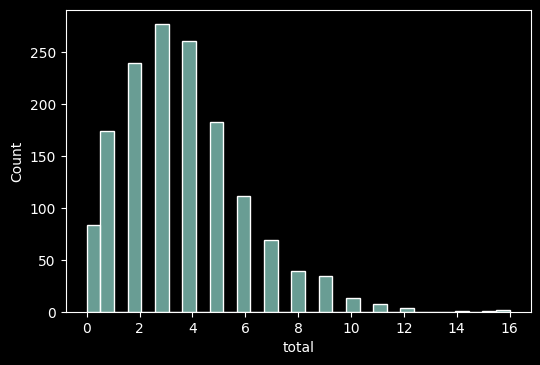

In [20]:
sns.histplot(df.total);

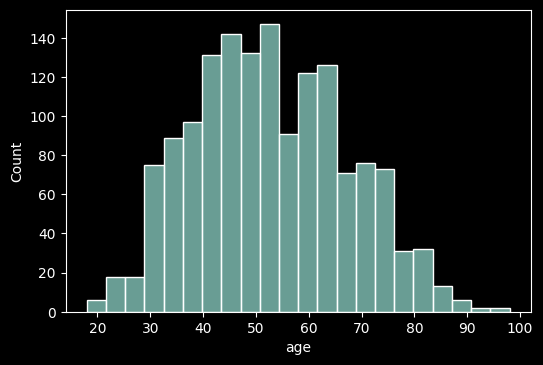

In [21]:
sns.histplot(df.age);

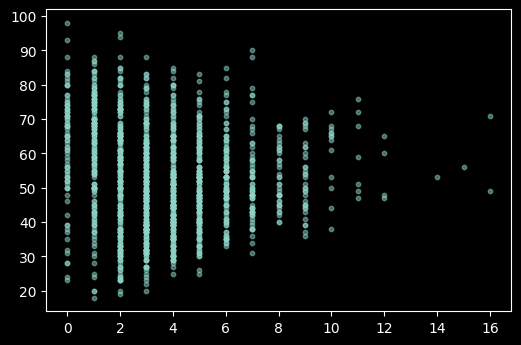

In [22]:
plt.scatter(x=df.total, y=df.age, alpha=.5, s=10);

### **Histogram by Age Division**

In [23]:
pd.cut(df.age, np.arange(15, 80, 5))

0       (60.0, 65.0]
1       (70.0, 75.0]
2       (50.0, 55.0]
3       (45.0, 50.0]
4       (70.0, 75.0]
            ...     
1495    (35.0, 40.0]
1496    (40.0, 45.0]
1497    (30.0, 35.0]
1498    (55.0, 60.0]
1499             NaN
Name: age, Length: 1500, dtype: category
Categories (12, interval[int64]): [(15, 20] < (20, 25] < (25, 30] < (30, 35] ... (55, 60] < (60, 65] < (65, 70] < (70, 75]]

In [24]:
age_groups = df.total.groupby(pd.cut(df.age, np.arange(15, 80, 5)))
age_groups.sum()

age
(15, 20]     10
(20, 25]     39
(25, 30]    143
(30, 35]    372
(35, 40]    607
(40, 45]    741
(45, 50]    871
(50, 55]    754
(55, 60]    552
(60, 65]    567
(65, 70]    384
(70, 75]    249
Name: total, dtype: int64

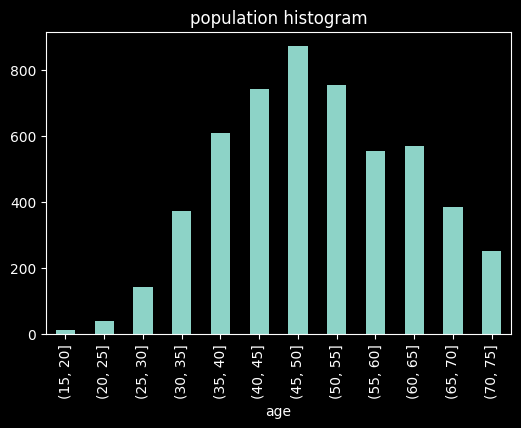

In [25]:
age_groups = df.total.groupby(pd.cut(df.age, np.arange(15, 80, 5)))
ax = age_groups.sum().plot(kind='bar');
ax.set(title='population histogram');

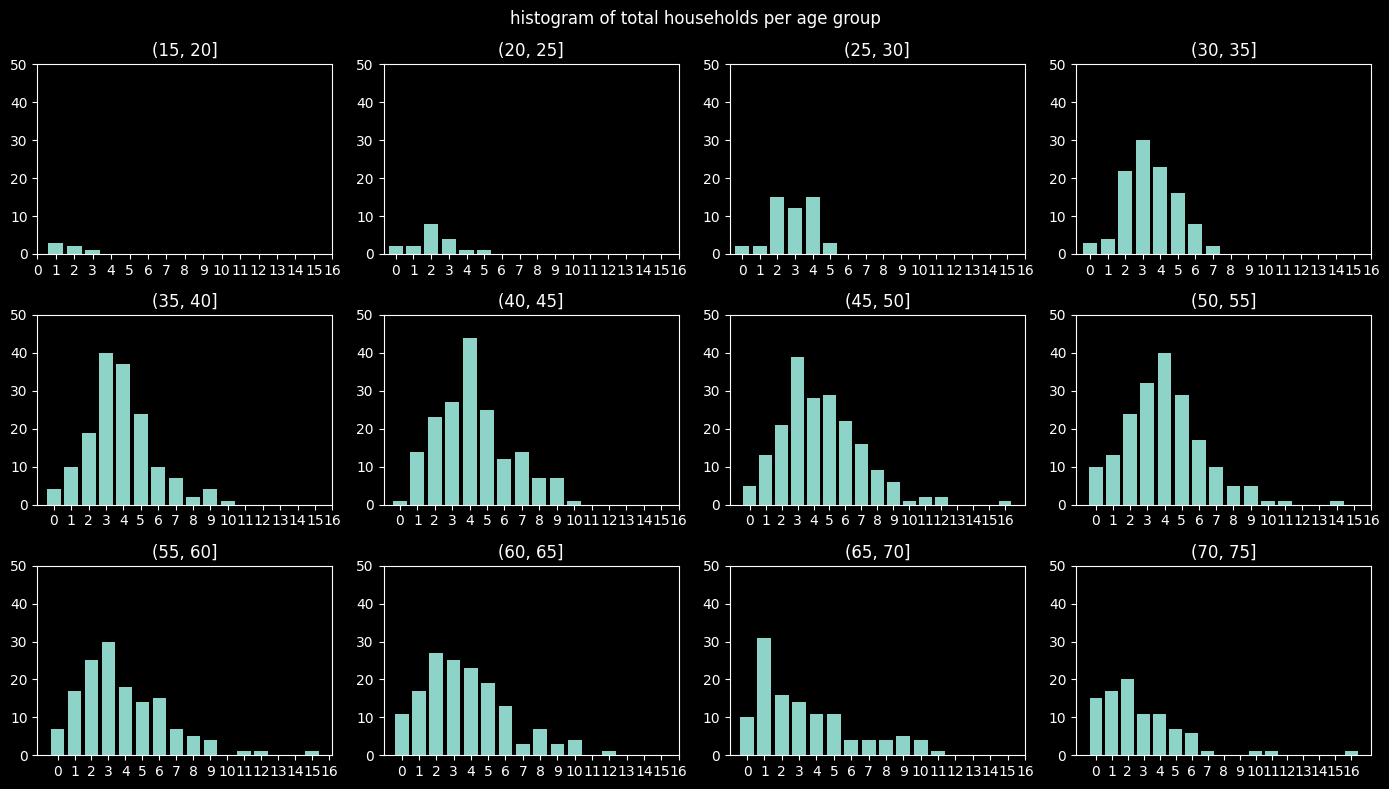

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(14,8))
for ax, g in zip(axes.ravel(), age_groups):
#     print(g[1])
    u, c = np.unique(g[1], return_counts=True)
    vc = g[1].value_counts()
    ax.bar(u, c)
    ax.set(title=g[0], xticks=np.arange(0, 17), ylim=[0,50])
fig.suptitle('histogram of total households per age group');
fig.tight_layout()

In [27]:
age_groups.apply(lambda x: (np.round(x.mean(), 3), np.round(x.std()**2, 3)))

age
(15, 20]    (1.667, 0.667)
(20, 25]    (2.167, 1.559)
(25, 30]     (2.918, 1.41)
(30, 35]    (3.444, 2.193)
(35, 40]    (3.842, 3.574)
(40, 45]    (4.234, 4.445)
(45, 50]     (4.49, 6.396)
(50, 55]    (4.011, 5.251)
(55, 60]    (3.807, 6.532)
(60, 65]    (3.706, 6.196)
(65, 70]    (3.339, 7.998)
(70, 75]    (2.736, 6.752)
Name: total, dtype: object

### log(mean households) - age

In [28]:
f = df.total.groupby(df.age).mean()
f = f[f != 0.]

[Text(0, 0.5, 'log( mean of households )')]

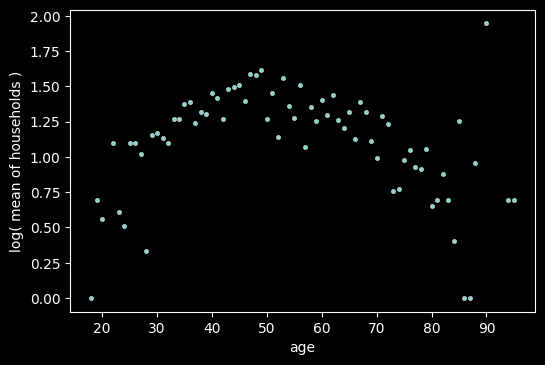

In [29]:
log_empirical_mean = np.log( f )
ax = sns.scatterplot(x=log_empirical_mean.index, y=log_empirical_mean, s=10);
ax.set(ylabel='log( mean of households )')

## Estimation & Inference

$$
    \log(\lambda) = b_0 + b_1 \cdot \mathrm{age} + b_2 \cdot \mathrm{age}^2
$$

In [30]:
def model(age, age2, households=None):
    b0 = numpyro.sample('b0', dist.Normal(0, 10))
    b1 = numpyro.sample('b1', dist.Normal(0, 10))
    b2 = numpyro.sample('b2', dist.Normal(0, 10))
    
    log_lambda = b0 + b1 * age + b2 * age2
    lamb = numpyro.deterministic('lamb', jnp.exp(log_lambda))
    with numpyro.plate('obsplate', size=len(age)):
        y = numpyro.sample('obs', dist.Poisson(rate = lamb), obs=households)

In [31]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)
#
#
mcmc.run(rngkey, df.age100.values, df.age1002.values, df.total.values)
#mcmc.run(rngkey, df.age.values, df.age2.values, df.total.values)
mcmc.print_summary(exclude_deterministic=True, prob=.8)

sample: 100%|██████████| 6000/6000 [00:10<00:00, 559.29it/s, 7 steps of size 3.18e-02. acc. prob=0.94]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        b0     -0.31      0.18     -0.31     -0.56     -0.08    608.00      1.00
        b1      7.00      0.71      6.99      6.07      7.91    592.30      1.00
        b2     -7.00      0.66     -7.00     -7.81     -6.11    596.63      1.00

Number of divergences: 0


In [32]:
s = mcmc.get_samples()
s

{'b0': DeviceArray([-0.18545581, -0.18109724, -0.20698607, ..., -0.2408373 ,
              -0.14147039, -0.14030626], dtype=float32),
 'b1': DeviceArray([6.4208827, 6.383951 , 6.353579 , ..., 6.6519156, 6.427951 ,
              6.4247093], dtype=float32),
 'b2': DeviceArray([-6.371971 , -6.2771106, -6.2486873, ..., -6.6123962,
              -6.4722605, -6.4621954], dtype=float32),
 'lamb': DeviceArray([[3.654502 , 2.8461647, 4.152682 , ..., 3.5291057, 4.0354786,
               2.5757105],
              [3.7299376, 2.9329   , 4.2031374, ..., 3.5388868, 4.09585  ,
               2.6628332],
              [3.606615 , 2.838601 , 4.062627 , ..., 3.4242506, 3.9591572,
               2.578233 ],
              ...,
              [3.6297731, 2.7972212, 4.1496444, ..., 3.5128264, 4.026363 ,
               2.5210485],
              [3.6772578, 2.8259554, 4.230466 , ..., 3.6540625, 4.093796 ,
               2.546215 ],
              [3.6894486, 2.8384001, 4.240414 , ..., 3.658544 , 4.10474  ,
    

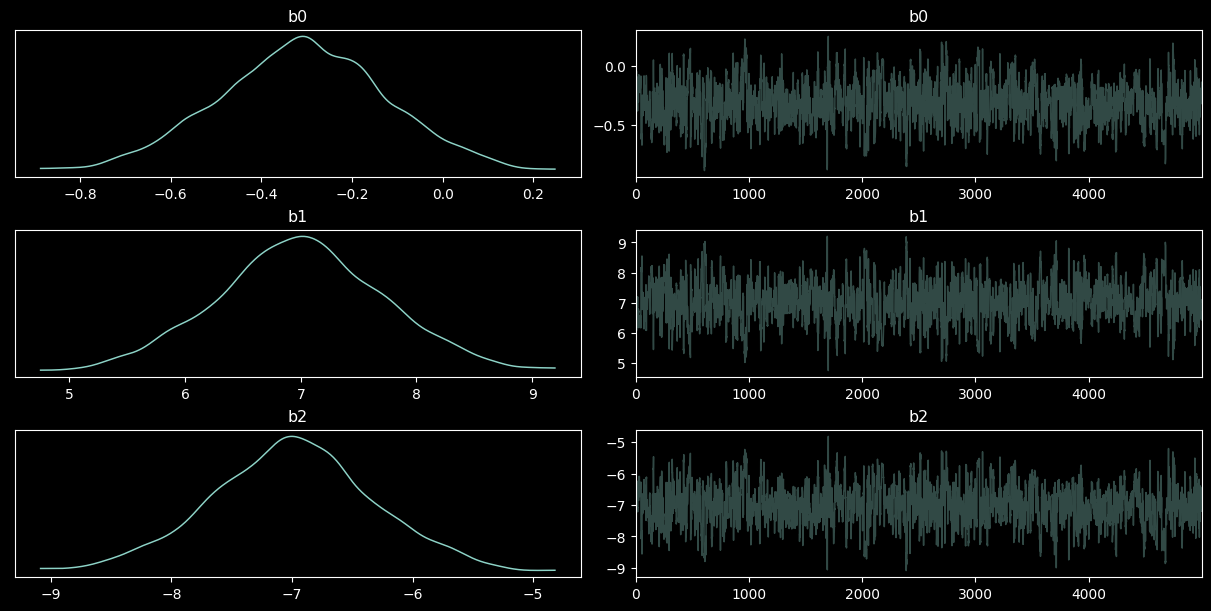

In [33]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['b0', 'b1', 'b2']);

In [34]:
s = mcmc.get_samples()
print_abs_summary(s, keys=['b0', 'b1', 'b2'])    # median statistic

          Med  MAD_SD
b0      -0.307   +0.182
b1      +6.992   +0.698
b2      -6.997   +0.640


-0.30981886 6.9976115 -6.998186


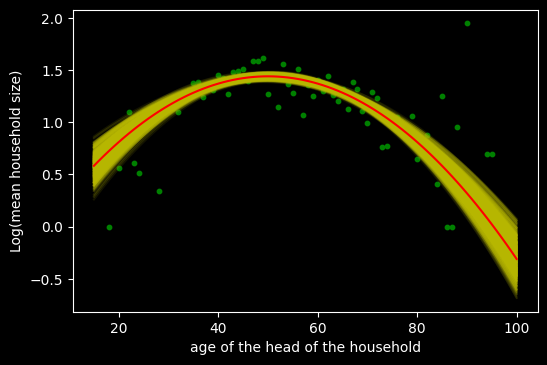

In [35]:
age100 = np.arange(15, 101) / 100.

# posterior samples
for i, (b0, b1, b2) in enumerate(zip(s['b0'], s['b1'], s['b2'])):
    log_pred = b0 + b1 * age100 + b2 * age100**2
    plt.plot(age100*100, log_pred, 'y-', alpha=.1)
    if i > 1000: break
plt.xlabel('age of the head of the household')
plt.ylabel('Log(mean household size)')

# posterior mean
b0m, b1m, b2m = s['b0'].mean(), s['b1'].mean(), s['b2'].mean()
print(b0m, b1m, b2m)
log_pred = b0m + b1m * age100 + b2m * age100**2
plt.plot(age100*100, log_pred, 'r-')
plt.scatter(log_empirical_mean.index, log_empirical_mean.values, color='g', s=10);

1. This model assumes a quadratic curve as the log of mean rate. This can be wrong.
    - Maybe cubic or higher degree polynomial.
    - Compare all the models and choose the best one, or
    - from multiple models, we may apply Bayesian model averaging which requires another theory on it.
    - If all these do not sound OK, then it is time to think about Gaussian Process Regression.
2. Observation data might be not sufficient for some age groups.
3. Poisson Really? We may use Negative Binomial to accommodate more dispersion (overdisperson) than Poisson. 

End.

In [37]:
!jupyter nbconvert Poisson_Regression.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Poisson_Regression.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 638612 bytes to Poisson_Regression.pdf
